In [1]:
# Imports:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
from IPython.display import display
import keras
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Input, Conv2DTranspose, Concatenate, BatchNormalization, UpSampling2D, ELU
from keras.layers import  Dropout, Activation
from keras.optimizers import Adam, SGD
# from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, CSVLogger
from keras import backend as K
from keras.utils import plot_model
from keras.metrics import BinaryIoU, Precision, Recall
from keras.losses import BinaryCrossentropy
import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow_addons.metrics import MatthewsCorrelationCoefficient, CohenKappa
import random
from itertools import islice
# import cv2
from random import shuffle

# KH: Stop tensorflow from grabbing the entire GPU, as we need to share it with someone else
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

2024-01-18 15:29:12.759559: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Load files here, define train, test, batch size

batch_size = 32

def sample_loader(dataset, split):
  data = tfds.load(dataset, split=split)
  data = data.map(lambda x: (x['image'], x['mask']))
  return tfds.as_numpy(data)

def batch_loader(dataset, split, batch_size):
  do_shuffle = (split == 'train')
  data = tfds.load(dataset, split=split, shuffle_files=do_shuffle)
  data = data.map(lambda x: (x['image'] / 255, x['mask'] > 0))
  if do_shuffle:
    data = data.shuffle(1024 * 16)
  data = data.batch(batch_size)
  return data

def show_sample(sample):
  image, mask = sample
  mask = np.concatenate([mask]*3, axis=-1)
  viz = np.concatenate([image, mask], axis=1)
  display(Image.fromarray(viz))

coasts_train = sample_loader('coastlines', 'train')
coasts_test = sample_loader('coastlines', 'test')
coasts_val = sample_loader('coastlines', 'val')

train_batches = batch_loader('coastlines', 'train', batch_size)
val_batches = batch_loader('coastlines', 'val', batch_size)

for image, mask in coasts_train:
  print(f'\nShape of image sample: {image.shape}')
  print(f'Shape of sample mask: {mask.shape}')
  break

print('\nTraining coast samples: ', len(coasts_train))
print('Validation samples: ', len(coasts_val))
print('Testing samples: ', len(coasts_test))

glaciers_train = sample_loader('glaciers', 'train')
glaciers_test = sample_loader('glaciers', 'test')
glaciers_val = sample_loader('glaciers', 'val')

print('\nTraining glaciers samples: ', len(glaciers_train))
print('Validation samples: ', len(glaciers_val))
print('Testing samples: ', len(glaciers_test))

# glaciers_ds = sample_loader('glaciers', 'train')
# print(len(glaciers_ds), 'samples of glaciers')

2024-01-18 15:29:18.655103: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-18 15:29:19.112116: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1637] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 20575 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:81:00.0, compute capability: 8.6



Shape of image sample: (512, 512, 3)
Shape of sample mask: (512, 512, 1)

Training coast samples:  420768
Validation samples:  24821
Testing samples:  26164

Training glaciers samples:  782
Validation samples:  120
Testing samples:  92


In [3]:
# Define Mean Intersection over Union (iou) metric: 
# LR: is this correct?
def mIoU_metric(y_true, y_pred):
    yt0 = K.cast(y_true[:,:,:,0] > 0.5, 'float32')
    yp0 = K.cast(y_pred[:,:,:,0] > 0.5, 'float32')

    inter0 = tf.math.count_nonzero(tf.math.logical_and(tf.math.equal(yt0, 0), tf.math.equal(yp0, 0)))
    union0 = tf.math.count_nonzero(tf.math.logical_or(tf.math.equal(yt0, 0), tf.math.equal(yp0, 0)))
    iou0 = tf.where(tf.equal(union0, 0), 1., tf.cast(inter0/union0, 'float32'))

    inter1 = tf.math.count_nonzero(tf.math.logical_and(tf.math.equal(yt0, 1), tf.math.equal(yp0, 1)))
    union1 = tf.math.count_nonzero(tf.math.add(yt0, yp0))
    iou1 = tf.where(tf.equal(union1, 0), 1., tf.cast(inter1/union1, 'float32'))    

    meanIoU = (iou0 + iou1)/2
    return meanIoU

In [4]:
# # Define the Sobel-edge loss function

# def sobel_edge_loss(y_true, y_pred):

#     yt0 = tf.cast(y_true, tf.float32)
#     yp0 = tf.cast(y_pred, tf.float32)

#     yt0 = K.cast(yt0[:,:,:,0] > 0.5, 'float32')
#     yp0 = K.cast(yp0[:,:,:,0] > 0.5, 'float32')

#     #this contains both X and Y sobel filters in the format (3,3,1,2)
#     #size is 3 x 3, it considers 1 input channel and has two output channels: X and Y
#     sobelFilter = K.variable([[[[1.,  1.]], [[0.,  2.]],[[-1.,  1.]]],
#                           [[[2.,  0.]], [[0.,  0.]],[[-2.,  0.]]],
#                           [[[1., -1.]], [[0., -2.]],[[-1., -1.]]]])
    
#     inputChannels = K.reshape(K.ones_like(y_true[0,0,0,:], 'float32'),(1,1,-1,1))
#     sobelFilter = sobelFilter*inputChannels

#     # calculate the sobel filters for yTrue and yPred
#     # this generates twice the number of input channels 
#     # a X and Y channel for each input channel
#     sobelTrue = K.depthwise_conv2d(yt0,sobelFilter)
    # sobelPred = K.depthwise_conv2d(yp0,sobelFilter)

    # # Calculate the mean squared error of the Sobel-filtered images
    # return K.mean(K.square(sobelTrue - sobelPred))

def sobel_edge_loss(y_true, y_pred):

    yt0 = tf.cast(y_true, tf.float32)
    yp0 = tf.cast(y_pred, tf.float32)

    # Calculate the Sobel edges for the ground truth and predicted images
    sobel_true = tf.image.sobel_edges(yt0)
    sobel_pred = tf.image.sobel_edges(yp0)

    # Calculate the mean squared error between the Sobel edges of the ground truth and predicted images
    loss = tf.reduce_mean(tf.square(sobel_true - sobel_pred))

    return loss

def sobel_crossentropy(y_true, y_pred):
    return sobel_edge_loss(y_true, y_pred) + 0.5*BinaryCrossentropy()(y_true, y_pred)


# def sobel_edge_loss(y_true, y_pred):
#     # Define the Sobel filters
#     sobel_x = tf.constant([[1, 0, -1], [2, 0, -2], [1, 0, -1]], dtype=tf.float32)
#     sobel_y = tf.constant([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], dtype=tf.float32)

#     # inputChannels = K.reshape(K.ones_like(y_true[0,0,0,:], 'float32'),(1,1,-1,1))
#     # sobel_x = sobel_x*inputChannels
#     # sobel_y = sobel_y*inputChannels

#     yt0 = tf.cast(y_true, tf.float32)
#     yp0 = tf.cast(y_pred, tf.float32)

#     yt0 = K.cast(yt0[:,:,:,0] > 0.5, 'float32')
    # yp0 = K.cast(yp0[:,:,:,0] > 0.5, 'float32')

    # yt0 = tf.expand_dims(yt0, axis=0)
    # yp0 = tf.expand_dims(yp0, axis=0)
    # yt0 = tf.expand_dims(yt0, axis=-1)
    # yp0 = tf.expand_dims(yp0, axis=-1)
    
    # # Apply Sobel filters to the true and predicted images
    # y_true_sobel_x = tf.nn.convolution(yt0, sobel_x, padding='SAME')
    # y_true_sobel_y = tf.nn.convolution(yt0, sobel_y, padding='SAME')
    # y_pred_sobel_x = tf.nn.convolution(yp0, sobel_x, padding='SAME')
    # y_pred_sobel_y = tf.nn.convolution(yp0, sobel_y, padding='SAME')

    # # Edge magnitudes:
    # y_true_sobel_mag = tf.math.sqrt(tf.math.square(y_true_sobel_x) + tf.math.square(y_true_sobel_y))
    # y_pred_sobel_mag = tf.math.sqrt(tf.math.square(y_pred_sobel_x) + tf.math.square(y_pred_sobel_y))

    # # Calculate the mean squared error of the Sobel-filtered images
    # sobel_loss = tf.math.reduce_mean(tf.math.square(y_true_sobel_mag - y_pred_sobel_mag))

    # return sobel_loss

In [5]:
# NN - model
def unet_CoastDetection(input_shape = (512, 512, 3)):       
  x = Input(input_shape)
  inputs = x

  #down sampling
  f = 8
  layers = []

  for i in range(0, 4):
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    # x = BatchNormalization()(x)
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    # x = BatchNormalization()(x)
    layers.append(x)
    x = MaxPooling2D() (x)
    f = f*2
  ff2 = 64

  #bottleneck
  j = len(layers) - 1
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  # x = BatchNormalization()(x)
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  # x = BatchNormalization()(x)
  x = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same') (x)
  x = Concatenate(axis=3)([x, layers[j]])
  j = j -1

  #upsampling
  for i in range(0, 3):
    ff2 = ff2//2
    f = f // 2
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    # x = BatchNormalization()(x)
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    # x = BatchNormalization()(x)
    x = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same') (x)
    x = Concatenate(axis=3)([x, layers[j]])
    j = j -1


  #classification
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  # x = BatchNormalization()(x)
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  # x = BatchNormalization()(x)
  outputs = Conv2D(1, 1, activation='sigmoid') (x)

  #model creation
  model = Model(inputs=[inputs], outputs=[outputs])
  model.compile(optimizer = 'adam', loss = sobel_edge_loss, metrics = ['accuracy', mIoU_metric])

  return model

In [7]:
# New model - taken from paper
# Sobel edge loss

def double_conv_block(x, num_filters):
    # Conv2D then ELU activation
    x = Conv2D(num_filters, 3, activation='relu', padding="same")(x)
    # x = BatchNormalization()(x)
    # x = ELU()(x)
    # Conv2D then ELU activation
    x = Conv2D(num_filters, 3, activation='relu', padding="same")(x)
    # x = BatchNormalization()(x)
    # x = ELU()(x)
    return x

def unet_CoastDetection(input_shape = (512, 512, 3)):       
  x = Input(input_shape)
  inputs = x

  #down sampling
  num_filters = 32
  layers = []

  # encoder path:
  for _ in range(0, 4):
    x = double_conv_block(x, num_filters)
    layers.append(x)
    x = MaxPooling2D(2)(x)
    num_filters = num_filters*2
  
  ff2 = num_filters // 2

  # bottleneck:
  j = len(layers) - 1
  x = double_conv_block(x, num_filters)
  x = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same') (x)
  x = Concatenate(axis=3)([x, layers[j]])
  j = j - 1

  #upsampling
  for _ in range(0, 3):
    ff2 = ff2 // 2
    num_filters = num_filters // 2
    x = double_conv_block(x, num_filters)
    x = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same')(x)
    x = Concatenate(axis=3)([x, layers[j]])
    j = j - 1

  # classification
  num_filters = num_filters // 2
  x = double_conv_block(x, num_filters)
  outputs = Conv2D(1, 1, activation='sigmoid')(x)

  #model creation
  model = Model(inputs=[inputs], outputs=[outputs])
  model.compile(optimizer = 'adam', loss = sobel_crossentropy, metrics = ['accuracy', Precision(), Recall(), BinaryIoU(), mIoU_metric])

  return model

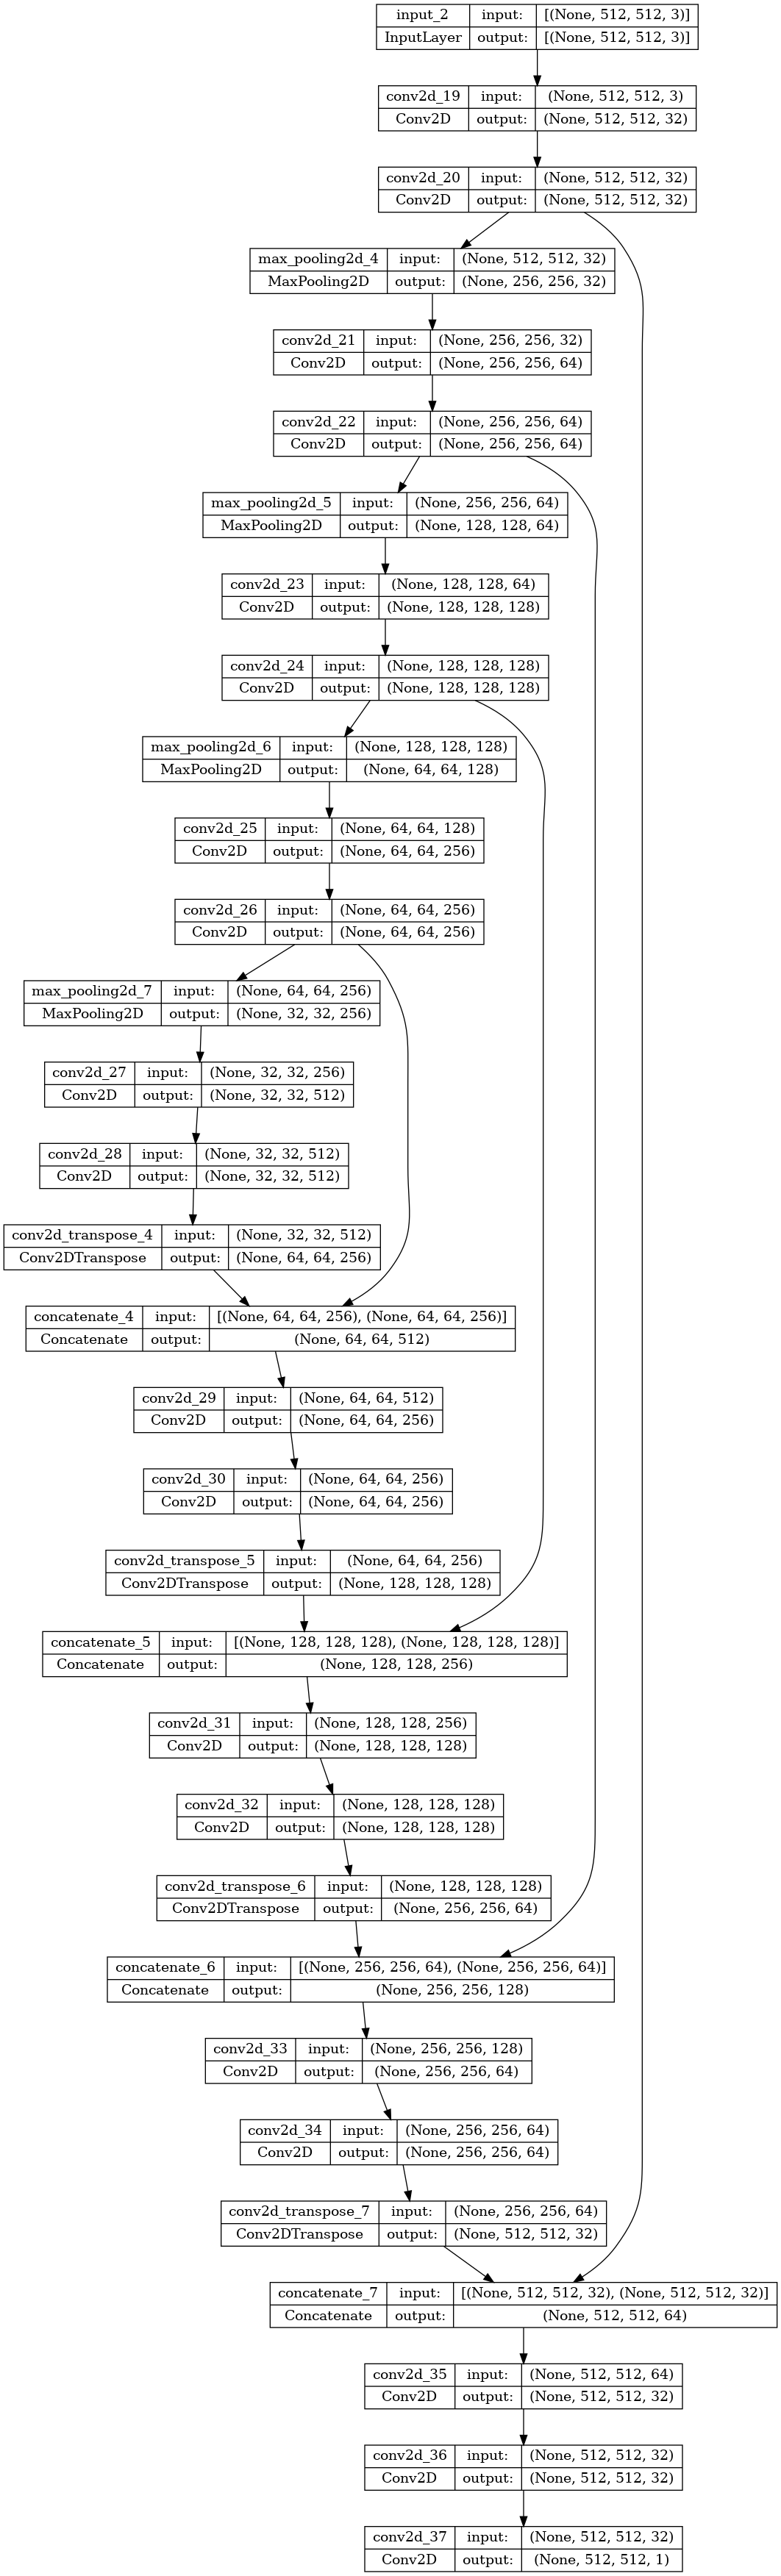

In [8]:
model = unet_CoastDetection()
# model.summary()
plot_model(model, to_file='./trained_models/model10.png', show_shapes=True)

In [8]:
# Callbacks
def build_callbacks(freq):
        checkpointer = ModelCheckpoint(filepath='./trained_models/test7-{epoch:03d}.h5', verbose=0, save_best_only=True, save_weights_only=True) # save_freq=freq)
        reduce_lr = ReduceLROnPlateau(factor=0.1, patience=5)
        log_csv = CSVLogger('./trained_models/cd_test_logs.csv', separator=',')
        early_stop = EarlyStopping(patience=10)       
        callbacks = [checkpointer, reduce_lr, log_csv, early_stop, PlotLearning()]
        # callbacks = [PlotLearning()]
        return callbacks

# inheritance for training process plot
class PlotLearning(keras.callbacks.Callback):

    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        #self.fig = plt.figure()
        self.logs = []
    def on_epoch_end(self, epoch, plot_prediction=False, logs={}):
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('mIoU_metric'))
        self.val_acc.append(logs.get('val_mIoU_metric'))
        self.i += 1
        print('\n i=',self.i,'loss=',logs.get('loss'),'val_loss=',logs.get('val_loss'),'mIoU_metric=',logs.get('mIoU_metric'),'val_mIoU_metric=',logs.get('val_mIoU_metric'))

        plot_prediction = True
        if plot_prediction:
            #choose a random test image and preprocess:
            img_index = random.randint(1, len(coasts_test))
            image, mask = list(islice(coasts_test, img_index-1, img_index))[0]

            # Predict the mask:
            pred = model.predict(np.asarray(image)[None, ...])

            # mask post-processing
            msk_pred  = pred[0,:,:,0]
            msk_pred = np.stack((msk_pred,)*3, axis=-1)
            msk_pred[msk_pred >= 0.5] = 1
            msk_pred[msk_pred < 0.5] = 0

            # show the mask and the segmented image
            combined = np.concatenate([image, msk_pred, image*msk_pred], axis = 1)
            plt.imshow(combined)
            plt.title(f'Prediction for test sample at epoch {self.i}')
            plt.axis('off')
            plt.show()

Epoch 1/50


2024-01-16 09:52:08.805443: I tensorflow/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8700


  6/400 [..............................] - ETA: 2:16 - loss: 0.0747 - accuracy: 0.5450 - precision: 0.5764 - recall: 0.5013 - binary_io_u: 0.3745 - mIoU_metric: 0.3865WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.1427s vs `on_train_batch_end` time: 0.1707s). Check your callbacks.


400/400 [==============================] - ETA: 0s - loss: 0.0124 - accuracy: 0.7988 - precision: 0.7735 - recall: 0.8269 - binary_io_u: 0.6650 - mIoU_metric: 0.6687
 i= 1 loss= None val_loss= None mIoU_metric= None val_mIoU_metric= None
1/1 [==============================] - 0s 461ms/step


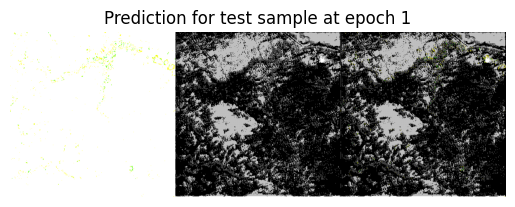

400/400 [==============================] - 346s 834ms/step - loss: 0.0124 - accuracy: 0.7988 - precision: 0.7735 - recall: 0.8269 - binary_io_u: 0.6650 - mIoU_metric: 0.6687 - val_loss: 0.0135 - val_accuracy: 0.7433 - val_precision: 0.6781 - val_recall: 0.9100 - val_binary_io_u: 0.5855 - val_mIoU_metric: 0.5842 - lr: 0.0010
Epoch 2/50
400/400 [==============================] - ETA: 0s - loss: 0.0100 - accuracy: 0.8114 - precision: 0.7986 - recall: 0.8153 - binary_io_u: 0.6826 - mIoU_metric: 0.6839
 i= 2 loss= None val_loss= None mIoU_metric= None val_mIoU_metric= None
1/1 [==============================] - 0s 29ms/step


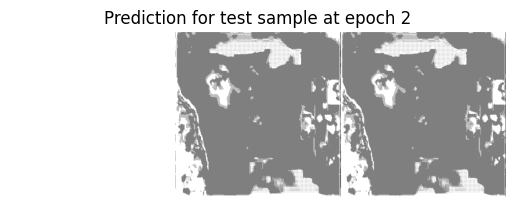

400/400 [==============================] - 331s 829ms/step - loss: 0.0100 - accuracy: 0.8114 - precision: 0.7986 - recall: 0.8153 - binary_io_u: 0.6826 - mIoU_metric: 0.6839 - val_loss: 0.0120 - val_accuracy: 0.7789 - val_precision: 0.8219 - val_recall: 0.7026 - val_binary_io_u: 0.6359 - val_mIoU_metric: 0.6337 - lr: 0.0010
Epoch 3/50
400/400 [==============================] - ETA: 0s - loss: 0.0095 - accuracy: 0.8220 - precision: 0.8058 - recall: 0.8340 - binary_io_u: 0.6977 - mIoU_metric: 0.7002
 i= 3 loss= None val_loss= None mIoU_metric= None val_mIoU_metric= None
1/1 [==============================] - 0s 25ms/step


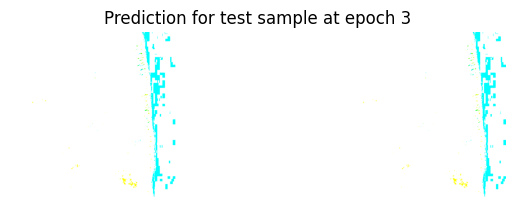

400/400 [==============================] - 326s 817ms/step - loss: 0.0095 - accuracy: 0.8220 - precision: 0.8058 - recall: 0.8340 - binary_io_u: 0.6977 - mIoU_metric: 0.7002 - val_loss: 0.0106 - val_accuracy: 0.8022 - val_precision: 0.8512 - val_recall: 0.7244 - val_binary_io_u: 0.6679 - val_mIoU_metric: 0.6652 - lr: 0.0010
Epoch 4/50
400/400 [==============================] - ETA: 0s - loss: 0.0095 - accuracy: 0.8181 - precision: 0.8057 - recall: 0.8209 - binary_io_u: 0.6921 - mIoU_metric: 0.6943

KeyboardInterrupt: 

In [9]:
# Training
EPOCHS = 50
train_steps = len(train_batches)
val_steps = len(val_batches)
model.fit(train_batches,
                    epochs = EPOCHS, steps_per_epoch = 400,
                    validation_data = val_batches, validation_steps = val_steps,
                    callbacks = build_callbacks(400)) # 10*train_steps

model.save('./trained_models/CoastDetection_model.keras')


In [ ]:
# Testing